# Fine-Tuning of CNN models

In order to transfer learning from a pre-trained models available in [Keras](https://keras.io/api/applications/) to solve specific problems, this project shows how to apply a famous machine learning technique called **fine-tuning**.

**Problem: [Domestic Garbage Detection](https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset/)**

## Steps
* Import the dataset;
* Exploration and preprocessing
* Compare 3 (or more) pre-trained models
* Evaluating the best model

## Importig libraries

In [221]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import prettytable
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, log_loss
from datetime import datetime

## Defining general constants

In [222]:
BATCH_SIZE=32
IMAGE_SIZE=(384, 512)
EPOCHS=200
SEED=10 

CURRENT_PATH = os.getcwd()
# DATASET_PATH = os.path.join(CURRENT_PATH, 'datasets', 'trash_type_dataset')
DATASET_PATH = os.path.join(CURRENT_PATH, 'datasets', 'dev')
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VALIDATION_PATH = os.path.join(DATASET_PATH, 'validation')
TEST_PATH = os.path.join(DATASET_PATH, 'test')

now_is = datetime.now().strftime('%d_%m_%YT%H_%M_%S')
EXPERIMENT_NAME = f"experiment_{now_is}"
BEST_MODEL_PATH = os.path.join(CURRENT_PATH, 'models', EXPERIMENT_NAME)

print(f"Executing the experiment '{EXPERIMENT_NAME}'")

Executing the experiment 'experiment_09_11_2024T20_14_20'


## Importing dataset

In [223]:
def import_dataset(dataset_path: str, batch_size: int = None):
    dataset = tf.keras.utils.image_dataset_from_directory(dataset_path,
                                                        labels='inferred',
                                                        label_mode='int',
                                                        batch_size=batch_size,
                                                        image_size=IMAGE_SIZE)
    return dataset

def import_datasets():
    print(f"[INFO] Importing training dataset from {TRAIN_PATH}")
    train_dataset = import_dataset(TRAIN_PATH, BATCH_SIZE)

    print(f"[INFO] Importing validation dataset from {VALIDATION_PATH}")
    validation_dataset = import_dataset(VALIDATION_PATH, BATCH_SIZE)

    print(f"[INFO] Importing test dataset from {TEST_PATH}")
    test_dataset = import_dataset(TEST_PATH, batch_size=None)

    return train_dataset, validation_dataset, test_dataset

In [224]:
train_dataset, validation_dataset, test_dataset = import_datasets()

[INFO] Importing training dataset from c:\Users\Gabriel\OneDrive\Documentos\projetos\gabriel\fine-tuning-cnns-example\datasets\dev\train
Found 6 files belonging to 6 classes.
[INFO] Importing validation dataset from c:\Users\Gabriel\OneDrive\Documentos\projetos\gabriel\fine-tuning-cnns-example\datasets\dev\validation
Found 6 files belonging to 6 classes.
[INFO] Importing test dataset from c:\Users\Gabriel\OneDrive\Documentos\projetos\gabriel\fine-tuning-cnns-example\datasets\dev\test
Found 6 files belonging to 6 classes.


## Exploring the dataset

What are the classes?

In [225]:
classes = train_dataset.class_names
print(f"The classes are {classes}")

The classes are ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Preview of the samples

In [226]:
def get_sample_of_dataset(dataset):
    image, label = next(iter(dataset))
    return image[0].numpy().astype(np.uint8), classes[label[0].numpy()]

def plot_n_samples(dataset, n: int, ncols = 4):
    samples = []
    nrows = (n // ncols) + 1
    figure, axis = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,8))

    figure.suptitle("Samples - Garbage Image Classification")

    for _ in range(len(samples)):
        samples.append(get_sample_of_dataset(dataset))

    for ax in axis.reshape(-1):
        image, label = get_sample_of_dataset(dataset)
        ax.set_title(f"[class={label}]")
        ax.imshow(image)
        ax.axis("off")

    plt.subplots_adjust(wspace=0)

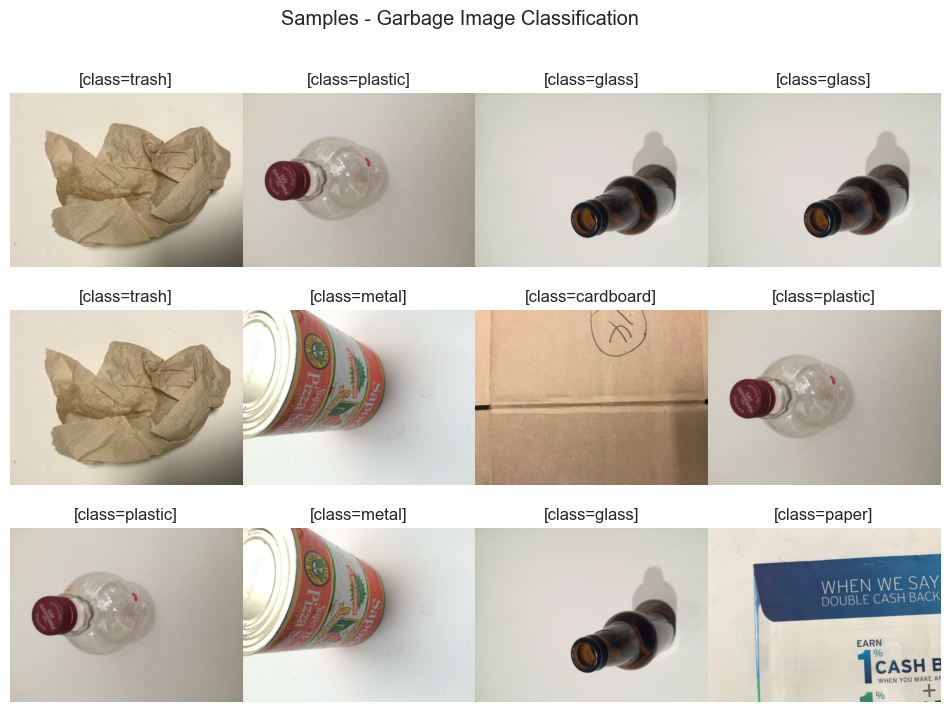

In [229]:
plot_n_samples(train_dataset, 10)

## Preparing experiments
For this project, some [available models](https://keras.io/api/applications/#available-models) were chosen to be compared using [Keras](https://keras.io/) framework. Below, it is described each used model:

|Model|Size (MB)|Top-1 Accuracy (ImageNet)|
|---|---|---|
|EfficientNetB7|256|84.3%|
|EfficientNetV2S|88|83.9%|
|ConvNeXtXLarge|1310|86.7%|

Before start the experiments, let's define some configurations and functions in order to re-use funcionalities.

In [210]:
class FineTuningModel:
    def __init__(self, 
                 title: str, 
                 base_model, 
                 input_shape = IMAGE_SIZE, 
                 batch_size = BATCH_SIZE):
        self.title = title
        self.base_model = base_model
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.best_model = None
        self.history = None
        self._freeze_base_model()

    def _freeze_base_model(self):
        self.base_model.trainable = False

    def _build(self, hp: kt.HyperParameters):
        dense_units = hp.Choice('dense_units', values=[256, 128, 64])
        
        # Conv Layers using a pre-trained model
        inputs = tf.keras.Input(shape=(*self.input_shape, 3))
        x = self.base_model(inputs, training=False)
        
        # Dense layers
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(dense_units, activation='relu')(x)
        outputs = tf.keras.layers.Dense(len(classes), activation='softmax')(x)
        
        # Compiling the model
        model = tf.keras.Model(inputs, outputs)
        model = self._compile(model, hp)
        return model

    def _compile(self, model: tf.keras.Model, hp: kt.HyperParameters):
        learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])
        return model

    def _get_best_model(self, train, validation, best_hps: list, callbacks: list):
        best_hp = best_hps[0]
        model = self._build(best_hp)
        self.history = model.fit(train, 
                  validation_data=validation, 
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS, 
                  callbacks=callbacks,
                  verbose=0)
        return model

    def train(self, train: tf.data.Dataset, validation: tf.data.Dataset):
        print(f"[INFO] Running experiment [{self.title}]")
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
        tuner = kt.Hyperband(hypermodel=self._build,
                            objective=kt.Objective('val_accuracy', direction='max'),
                            overwrite=True,
                            directory='checkpoints',
                            project_name=self.title,
                            max_epochs=EPOCHS)
        
        tuner.search(train, 
                     batch_size=BATCH_SIZE, 
                     validation_data=validation,
                     callbacks=callbacks)
        
        self.best_model = self._get_best_model(train,
                                                validation,
                                                tuner.get_best_hyperparameters(5),
                                                callbacks)

Defining the experiments

In [211]:
input_shape = (*IMAGE_SIZE, 3)
experiments = [
    FineTuningModel('EfficientNetB7', 
                    tf.keras.applications.EfficientNetB7(include_top=False, input_shape=input_shape)),
    FineTuningModel('EfficientNetV2S', 
                    tf.keras.applications.EfficientNetV2S(include_top=False, input_shape=input_shape))
]

## Training

In [212]:
for experiment in experiments:
    experiment.train(train=train_dataset, validation=validation_dataset)

Trial 2 Complete [00h 00m 28s]
val_accuracy: 0.3333333432674408

Best val_accuracy So Far: 0.3333333432674408
Total elapsed time: 00h 00m 58s


## Evaluating the best experiment

Comparing the training history

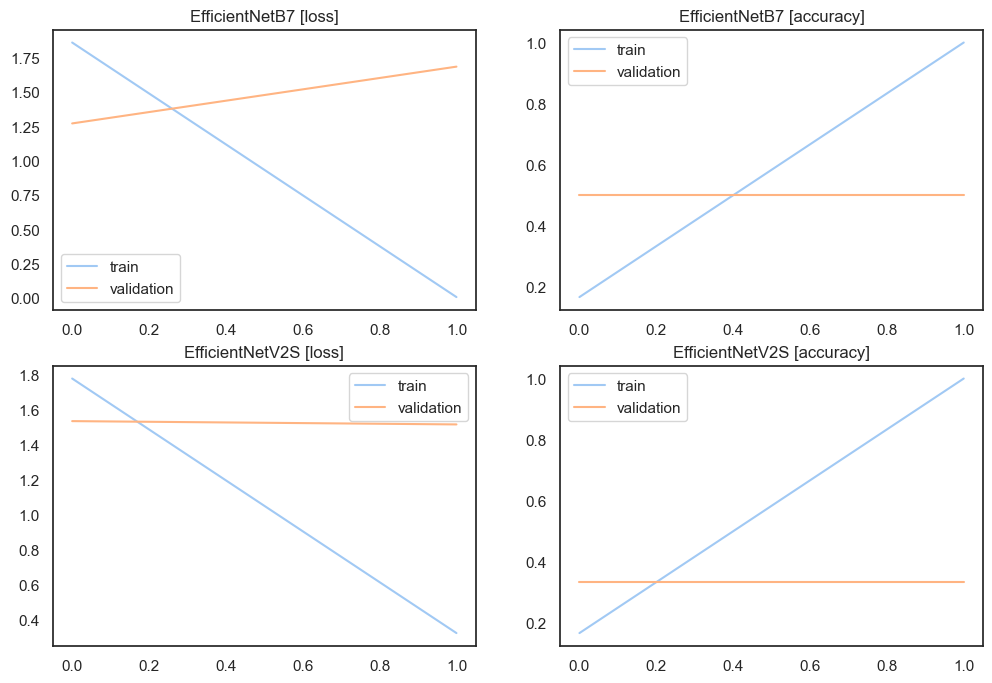

In [213]:
number_of_experiments = len(experiments)

figure, axis = plt.subplots(nrows=number_of_experiments, ncols=2, squeeze=False)
figure.set_figwidth(12)
figure.set_figheight(number_of_experiments*4)

for index in range(number_of_experiments):
    experiment = experiments[index]
    history = experiment.history.history
    title = experiment.title
    
    # Plotting loss
    axis[index][0].set_title(f'{title} [loss]')
    axis[index][0].plot(history['loss'], label="train")
    axis[index][0].plot(history['val_loss'], label="validation")
    axis[index][0].legend()
    
    # Plotting accuracy
    axis[index][1].set_title(f'{title} [accuracy]')
    axis[index][1].plot(history['accuracy'], label="train")
    axis[index][1].plot(history['val_accuracy'], label="validation")
    axis[index][1].legend()

Evaluating the best experiment based on the testing partition. First of all, let's create the truth array with the labels of the testing dataset.

In [214]:
number_os_tests = len(test_dataset)
y_true = np.ndarray(shape=(number_os_tests,), dtype=np.int8)
index = 0
for _, y in test_dataset:
    y = y.numpy()
    y_true[index] = y
    index += 1

Predicting...

In [215]:
test_dataset_as_batch = test_dataset.batch(1)
probabilities = np.ndarray(shape=(number_of_experiments, number_os_tests, len(classes)), dtype=np.float32)
predictions = np.ndarray(shape=(number_of_experiments, number_os_tests, ), dtype=np.int8)

index = 0
for experiment in experiments:
    best_model = experiment.best_model
    
    # Making predictions
    experiment_probabilities = best_model.predict(test_dataset_as_batch, verbose=0)
    experiment_predictions = [np.argmax(probability) for probability in experiment_probabilities]
    
    # Storing the predictions 
    probabilities[index] = experiment_probabilities
    predictions[index] = experiment_predictions
    
    index += 1

Plotting the metrics of each experiment's result

In [216]:
def format_float(value: float, percent=True):
    if percent:
        return f'{value*100:.2f}%'
    return f'{value:.2f}'

index = 0
table = prettytable.PrettyTable()
table.title = 'Fine-Tuning pre-trained models -- Results'
table.field_names = ['Experiment', 'Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC AUC', 'Log loss']

for experiment in experiments:
    title = experiment.title
    y_pred = predictions[index]
    y_probabilities = probabilities[index]

    # Calculating the metrics
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true=y_true, y_pred=y_pred, average='macro')
    logl = log_loss(y_true=y_true, y_pred=y_probabilities)
    rocauc = roc_auc_score(y_true=y_true, y_score=y_probabilities, multi_class='ovr')
    
    # Adding the metrics to table
    table.add_row([title, 
                   format_float(accuracy), 
                   format_float(f1), 
                   format_float(precision), 
                   format_float(recall),
                   format_float(logl, percent=False),
                   format_float(rocauc, percent=False)])

    index += 1

print(table)

+---------------------------------------------------------------------------------+
|                    Fine-Tuning pre-trained models -- Results                    |
+-----------------+----------+----------+-----------+--------+---------+----------+
|    Experiment   | Accuracy | F1-Score | Precision | Recall | ROC AUC | Log loss |
+-----------------+----------+----------+-----------+--------+---------+----------+
|  EfficientNetB7 |  33.33%  |  33.33%  |   33.33%  | 33.33% |   4.10  |   0.47   |
| EfficientNetV2S |  50.00%  |  44.44%  |   41.67%  | 50.00% |   2.18  |   0.57   |
+-----------------+----------+----------+-----------+--------+---------+----------+


Plotting the confusion matrix of each experiment

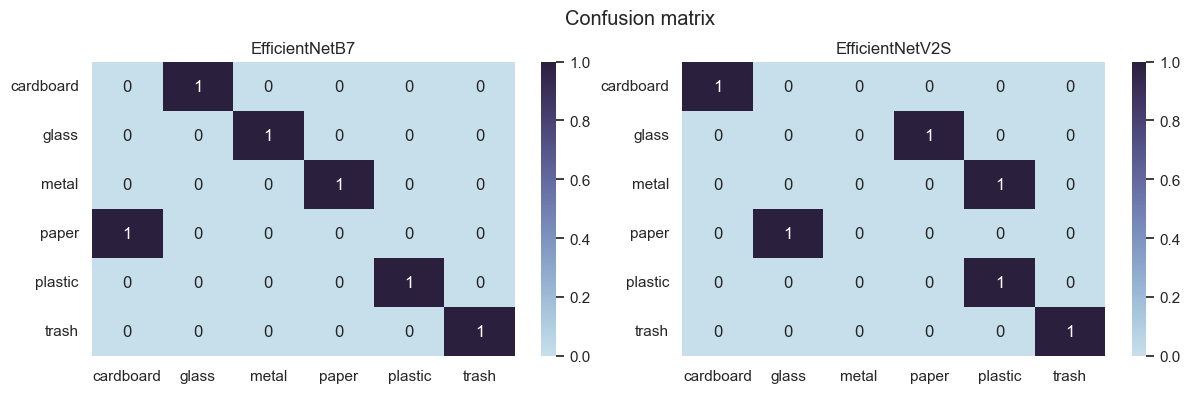

In [219]:
pallet = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

nrows = (number_of_experiments // 2)
if number_of_experiments % 2 != 0:
    nrows += 1 

figure, axis = plt.subplots(nrows=nrows, ncols=2, squeeze=False)
figure.suptitle('Confusion matrix')
figure.set_figwidth(12)
figure.set_figheight(nrows * 4)
figure.tight_layout(w_pad = 1, h_pad=4)

index_col = 0
for index in range(number_of_experiments):
    index_row = index // 2
    experiment = experiments[index]
    y_pred = predictions[index]
    title = experiment.title

    # Calculating the confusion matrix
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    
    # Plotting confusion matrix
    axis[index_row, index_col].set_title(title)
    sns.heatmap(ax=axis[index_row, index_col], 
                data=cm, 
                xticklabels=classes, 
                yticklabels=classes, 
                fmt='.0f',
                cmap=pallet,
                annot=True)
    
    index_col = 1 if index_col == 0 else 0

if number_of_experiments % 2 != 0:
    axis[-1][1].axis('off')

Saving each trained model

In [220]:
for experiment in experiments:
    title = experiment.title
    print(f"[INFO] Saving {title}")
    best_model = experiment.best_model
    model_name = f"Model_{title}"
    model_path = os.path.join(BEST_MODEL_PATH, model_name)
    best_model.save(model_path, overwrite=False)

[INFO] Saving EfficientNetB7


INFO:tensorflow:Assets written to: c:\Users\Gabriel\OneDrive\Documentos\projetos\gabriel\fine-tuning-cnns-example\experiment_09_11_2024T19_56_03\models\Model_EfficientNetB7\assets


INFO:tensorflow:Assets written to: c:\Users\Gabriel\OneDrive\Documentos\projetos\gabriel\fine-tuning-cnns-example\experiment_09_11_2024T19_56_03\models\Model_EfficientNetB7\assets


KeyboardInterrupt: 

## Conclusion